## Exercise 0

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os
from numpy import unravel_index
import time

In [120]:

start_time = time.time()
files_train = {}
files_test = {}

for path in os.listdir('UCRArchive_2018'):
    updated_path = "".join(('UCRArchive_2018', "/", path))
    for file in os.listdir(updated_path):
        if "TEST.tsv" in file:
            te_path = "".join((updated_path, "/", file))
            files_test[path] = te_path
        elif "TRAIN.tsv" in file:
            tr_path = "".join((updated_path, "/", file))
            files_train[path] = tr_path


dct = {}
for (train, fname_tr), (test, fname_te) in zip(files_train.items(), files_test.items()):
    test_df = pd.read_csv(fname_te, sep = '\t', header = None)    
    train_df = pd.read_csv(fname_tr, sep = '\t', header = None)	
    temp_df = pd.concat([train_df, test_df])
    
    norml_df = (temp_df - temp_df.mean()) / temp_df.std()   #standardize
    norml_df[0] = temp_df[0]
    
    pad_df = norml_df.copy()
    for m in range(len(norml_df.index)):
        if str(norml_df.iloc[m, -1]) == 'nan':
            length = norml_df.iloc[m, :].last_valid_index()
            norml_df.iloc[m, :] = norml_df.iloc[m, :].shift(axis = 0, periods = len(norml_df.columns) - length
                                                            , fill_value = 0)
        norml_df[0] = pad_df[0] 
    n_pad_df = norml_df
    
    n_pad_df = n_pad_df.reset_index(drop = True)
    df_grp = n_pad_df.groupby(0).apply(lambda x:x.sample(frac = 0.7, random_state = 3116))
    a, b = zip(*df_grp.index)
    df_grp.index = list(b)
    df_grp_t = n_pad_df.drop(df_grp.index)
    df_grp_2 = df_grp_t.groupby(0).apply(lambda x:x.sample(frac = 0.5, random_state = 3116))
    c, d = zip(*df_grp_2.index)
    df_grp_2.index = list(d)
    df_grp_3 = df_grp_t.drop(df_grp_2.index)
    
    dct[train] = [df_grp, df_grp_2, df_grp_3]
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 818.2322821617126 seconds ---


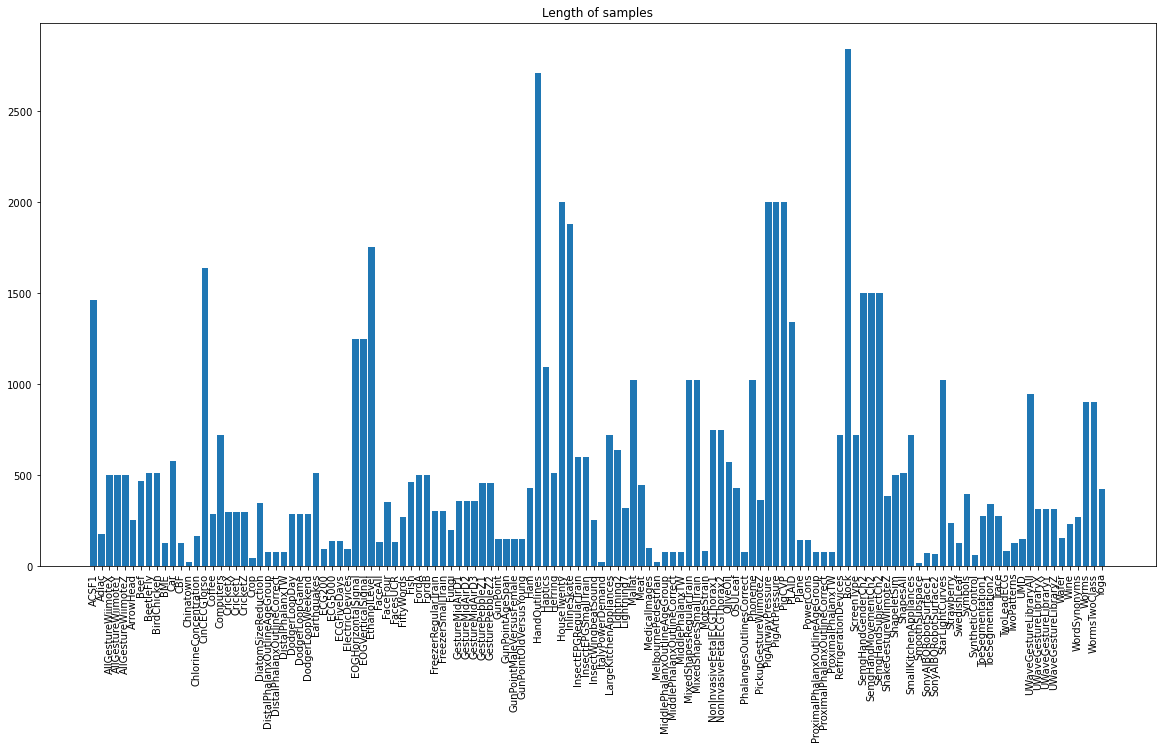

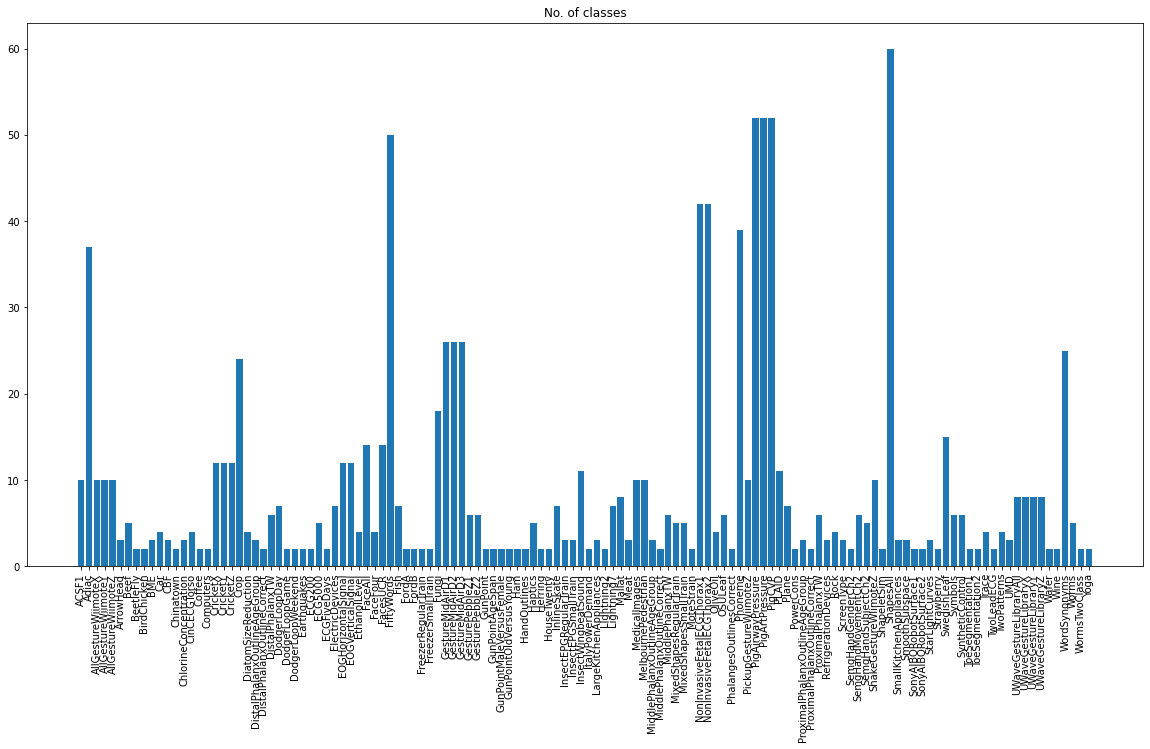

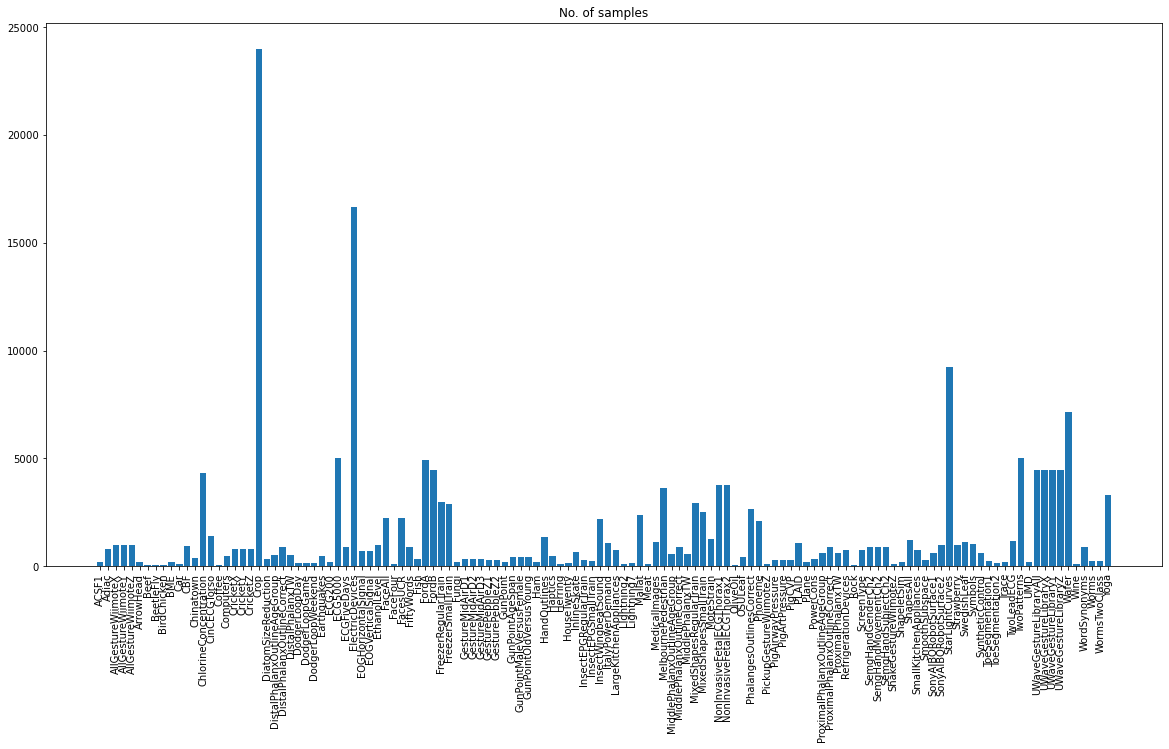

In [100]:
# Plotting
def plot_func(x, y, text):
    plt.figure(figsize = (20, 10))
    plt.bar(x, y)
    plt.title(text)
    plt.xticks(rotation = 90)
    plt.show()

smp, d_names, n_class, smp_len = [], [], [], []
dct_cp = copy.deepcopy(dct)
for i, j in dct_cp.items():
    dtmp = np.vstack((j))
    n_class.append(len(np.unique(dtmp[:, 0])))
    x, y = np.shape(dtmp)
    smp.append(x)
    smp_len.append(y)
    d_names.append(i)

plot_func(d_names, smp_len, 'Length of samples')
plot_func(d_names, n_class, 'No. of classes')
plot_func(d_names, smp, 'No. of samples')

## Exercise 1

In [108]:
# 1.
dfs_f = copy.deepcopy(dct)
miss = {}
missVal_df = {}
for k, v in dfs_f.items():
    cdf_t = pd.concat(v)
    if np.count_nonzero(cdf_t.isnull()) != 0:
        miss[k] = v
        missVal_df[k] = np.count_nonzero(cdf_t.isnull())
print('Missing values in datasets : ', list(missVal_df.keys()))

Missing values in datasets :  ['AllGestureWiimoteY', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'MelbournePedestrian', 'PickupGestureWiimoteZ', 'ShakeGestureWiimoteZ']


In [123]:
# 2,3.
start_time = time.time()
def kmeans(imp_df, imp):
    temp_df = imp_df.copy()
    temp_x = temp_df.drop(0, axis = 1)
    temp_x_np = temp_x.to_numpy()

    for i in range(len(imp_df.index)):
        if np.count_nonzero(imp_df.iloc[i, :].isnull()) != 0:           
            d = np.sqrt(np.sum(np.square(temp_x_np[i, :] - temp_x_np), axis = 1))
            k_class = list(np.argsort(d)[1:imp + 1])
            m = np.mean(temp_x_np[k_class, :])
            imp_df.iloc[i, :] = imp_df.iloc[i, :].fillna(m)
    return imp_df, imp

def grid_search(df_train, df_val):
    imp_m = 10 
    cls_m = 10 
    accArray = np.zeros((8, 9))
    
    for i in range(2, imp_m):
        df_train2, i = kmeans(df_train, i)
        df_val2, i = kmeans(df_val, i)
        
        df_train2_x = df_train2.drop(0, axis = 1).to_numpy()
        df_train2_y = df_train2[0].to_numpy()
        df_val2_x = df_val2.drop(0, axis = 1).to_numpy()
        df_val2_y = df_val2[0].to_numpy()
        for j in range(1, cls_m):
            y_pred = np.zeros(np.shape(df_val2_y))
            for k in range(np.shape(df_val2_x)[0]):
                d = np.sqrt(np.sum(np.square(df_val2_x[k, :] - df_train2_x), axis = 1))
                k_class = list(np.argsort(d)[0:j])
                clss, cnts = np.unique(df_train2_y[k_class], return_counts = True)
                f = np.argmax(cnts)
                y_pred[k] = clss[f]
            accArray[i-2, j-1] = np.around((np.sum(np.round(df_val2_y) == np.round(y_pred)) / len(df_val2_y)) * 100, 4)


    indx = unravel_index(accArray.argmax(), accArray.shape)
    i = indx[0] + 2
    j = indx[1] + 1
    return df_train2, df_val2, i, j

dct_u = {}
miss_c = copy.deepcopy(miss)
miss_c.items()

for k, mVal in miss_c.items():
    trainn_df = mVal[0]
    vall_df = mVal[1]
    testt_df = mVal[2]
    
    df_train, df_val, imp, clsss = grid_search(trainn_df, vall_df)
    dct_u[k] = [trainn_df, vall_df, testt_df, imp, clsss]

print("--- %s seconds ---" % (time.time() - start_time))


--- 152.96700191497803 seconds ---


In [132]:
# 4.

dct_c = copy.deepcopy(dct_u)
optimal_dct ={}
for key, val in dct_c.items():
    trainn_df, vall_df, testt_df, impp, clss = val[0], val[1], val[2], val[3], val[4]
    print('For dataset : ' + str(key) + ' where k1 = ' + str(impp) + ' and k2 = ' + str(clss))    
    df_trainn, impp = kmeans(trainn_df, impp)
    df_vall, impp = kmeans(vall_df, impp)
    df_testt, impp = kmeans(testt_df, impp)
    df_train_x = df_trainn.drop(0, axis = 1).to_numpy()
    df_train_y = df_trainn[0].to_numpy()
    df_val_x = df_vall.drop(0, axis = 1).to_numpy()
    df_val_y = df_vall[0].to_numpy()
    df_test_x = df_testt.drop(0, axis = 1).to_numpy()
    df_test_y = df_testt[0].to_numpy()

    val_y_pred = np.zeros(np.shape(df_val_y))
    for u in range(np.shape(df_val_x)[0]):
        d = np.sqrt(np.sum(np.square(df_val_x[u, :] - df_train_x), axis = 1))
        k_class = list(np.argsort(d)[0:clss])
        clss2, cnts = np.unique(df_train_y[k_class], return_counts = True)
        f = np.argmax(cnts)
        val_y_pred[u] = clss2[f]

    print('Final validation accuracy: ', str(np.around(accu(df_val_y, val_y_pred) * 100, 4)) + ' %')

    tst_y_pred = np.zeros(np.shape(df_test_y))
    for v in range(np.shape(df_test_x)[0]):
        d = np.sqrt(np.sum(np.square(df_test_x[v, :] - df_train_x), axis = 1))
        k_class = list(np.argsort(d)[0:clss])
        clss2, cnts = np.unique(df_train_y[k_class], return_counts = True)
        f = np.argmax(cnts)
        tst_y_pred[v] = clss2[f]

    print('Final test accuracy: '+ str(np.around(accu(df_test_y, tst_y_pred) * 100, 4)) + ' %\n')
    
    optimal_dct[key] = [df_trainn, df_vall, df_testt, impp, clss]


For dataset : AllGestureWiimoteY where k1 = 2 and k2 = 1
Final validation accuracy:  50.6667 %
Final test accuracy: 37.3333 %

For dataset : DodgerLoopDay where k1 = 2 and k2 = 8
Final validation accuracy:  65.3846 %
Final test accuracy: 52.381 %

For dataset : DodgerLoopGame where k1 = 2 and k2 = 1
Final validation accuracy:  87.5 %
Final test accuracy: 91.6667 %

For dataset : DodgerLoopWeekend where k1 = 2 and k2 = 1
Final validation accuracy:  100.0 %
Final test accuracy: 100.0 %

For dataset : MelbournePedestrian where k1 = 2 and k2 = 1
Final validation accuracy:  95.9707 %
Final test accuracy: 95.8029 %

For dataset : PickupGestureWiimoteZ where k1 = 2 and k2 = 1
Final validation accuracy:  55.0 %
Final test accuracy: 50.0 %

For dataset : ShakeGestureWiimoteZ where k1 = 2 and k2 = 1
Final validation accuracy:  60.0 %
Final test accuracy: 40.0 %



## Exercise 2

In [143]:
from scipy.spatial.distance import pdist

def grid_search_n(df_train, df_val, distList):
    k_max = 8
    accArray = np.zeros((k_max - 1, len(distList)))
    for k in range(1, k_max):
        df_train2_x = df_train.drop(0, axis = 1).to_numpy()
        df_train2_y = df_train[0].to_numpy()
        df_val2_x = df_val.drop(0, axis = 1).to_numpy()
        df_val2_y = df_val[0].to_numpy()
        for dst in distList:
            y_pred = np.zeros(np.shape(df_val2_y), dtype = int)
            for r in range(np.shape(df_val2_x)[0]):
                df_merge_x = np.append(df_val2_x[r, :].reshape(1,len(df_val2_x[r, :])), df_train2_x, axis = 0)				
                dist = pdist(df_merge_x, dst)[0:np.shape(df_train2_x)[0]]
                k_class = list(np.argsort(dist))[0:k]
                clss, cnts = np.unique(df_train2_y[k_class], return_counts = True)
                indx = np.argmax(cnts)
                y_pred[r] = clss[indx]
            accArray[k - 1, distList.index(dst)] = np.around((np.sum(np.round(df_val2_y) == np.round(y_pred))/len(df_val2_y)) * 100, 4)
    return np.argmax(accArray, axis = 0).flatten() + 1, distList, accArray.max(axis = 0)

test2_df = {}
d_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation','cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon',
             'kulsinski', 'matching', 'minkowski', 'rogerstanimoto','russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
dct2_c = copy.deepcopy(dct)
for i, jVal in dct2_c.items():
    tempp = np.vstack(jVal)
    if np.shape(tempp)[0] < 400 and np.shape(tempp)[1] < 200:
        test2_df[i] = jVal

print('We select following database since have low computation power : ' + 
      str(len(test2_df.keys())))
d_names = list(test2_df.keys()) 
print(d_names)
              
accuList = np.zeros((len(test2_df.keys()), len(d_metrics)))
f = 0
for keyy, vall in test2_df.items():
    df_t_train, df_t_val, df_t_test = vall[0], vall[1], vall[2]
    
    kVal_o, dMetric_o, accu_o = grid_search_n(df_t_train, df_t_val, d_metrics)
    df2_train_x = df_t_train.drop(0, axis = 1).to_numpy()
    df2_train_y = df_t_train[0].to_numpy()
    df2_test_x = df_t_test.drop(0, axis = 1).to_numpy()
    df2_test_y = df_t_test[0].to_numpy()
    tst_y_pred = np.zeros(np.shape(df2_test_y))
    print('Dataset: ', keyy)
    for dd in range(len(dMetric_o)):
        for r in range(np.shape(df2_test_x)[0]):
            df_merge_x = np.append(df2_test_x[r,:].reshape(1,len(df2_test_x[r,:])), df2_train_x, axis=0)
            dist = pdist(df_merge_x, dMetric_o[dd])[0:np.shape(df2_train_x)[0]]
            k_class = list(np.argsort(dist))[0:kVal_o[dd]]
            clss, cnts = np.unique(df2_train_y[k_class], return_counts = True)
            indx = np.argmax(cnts)
            tst_y_pred[r] = clss[indx]

        print('Optimal Parameters [Distance Metric, K Value, Testing Accuracy]: ', dMetric_o[dd], kVal_o[dd], np.around((np.sum(np.round(df2_test_y) == np.round(tst_y_pred))/len(df2_test_y)) * 100, 4))
        accuList[f, dd] = np.around((np.sum(np.round(df2_test_y) == np.round(tst_y_pred))/len(df2_test_y)) * 100, 4)
    f = f + 1

We select following database since have low computation power : 8
['BME', 'Chinatown', 'ECG200', 'GunPoint', 'Plane', 'PowerCons', 'SmoothSubspace', 'UMD']
Dataset:  BME
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  braycurtis 1 100.0
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  canberra 4 92.5926
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  chebyshev 1 85.1852
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  cityblock 1 96.2963
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  correlation 1 96.2963
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  cosine 1 96.2963
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  dice 1 33.3333
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  euclidean 1 96.2963
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  hamming 3 59.2593
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  

Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  jaccard 1 14.2857
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  jensenshannon 1 14.2857
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  kulsinski 1 14.2857
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  matching 1 14.2857
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  minkowski 1 97.1429
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  rogerstanimoto 1 14.2857
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  russellrao 1 14.2857
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  seuclidean 1 97.1429
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  sokalmichener 1 14.2857
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  sokalsneath 1 14.2857
Optimal Parameters [Distance Metric, K Value, Testing Accuracy]:  sqeuclidean 1 97.1429
Optimal Parameters [Distance Metric, K

## Exercise 3

In [153]:
def grid_search_n2(df_train, df_val):
    k_min = 1
    k_max = 10
    accArray = np.zeros((k_max - k_min, 1))
    for k in range(k_min, k_max):
        accuList = []   
        df_train2_x = df_train.drop(0, axis = 1).to_numpy()
        df_train2_y = df_train[0].to_numpy()
        df_val2_x = df_val.drop(0, axis = 1).to_numpy()
        df_val2_y = df_val[0].to_numpy()
        y_pred = np.zeros(np.shape(df_val2_y))
        for l in range(np.shape(df_val2_x)[0]):
            d = np.zeros((1, np.shape(df_train2_x)[0]))
            for m in range(np.shape(df_train2_x)[0]):
                if m < k:
                    d[0, m] = np.sum(np.square(df_val2_x[l, :] - df_train2_x[m, :]))
                else:
                    tmp, p_d = 0, 0
                    while p_d < np.max(d) and tmp < np.shape(df_train2_x)[1]:
                        p_d = p_d + np.square(df_val2_x[l, tmp] - df_train2_x[m, tmp])
                        tmp = tmp + 1
                    if p_d < np.max(d) and tmp == np.shape(df_train2_x)[1]:
                        d[0, m] = p_d
                    else:
                        d[0, m] = np.max(d)
            k_class = list(np.argsort(d.flatten()))[0:k]
            clss, cnts = np.unique(df_train2_y[k_class], return_counts = True)
            indx = np.argmax(cnts)
            y_pred[l] = clss[indx]
        accuList.append(np.sum(np.round(df_val2_y) == np.round(y_pred))/len(df_val2_y))
        accArray[k - k_min, 0] = np.around((np.sum(np.round(df_val2_y) == np.round(y_pred))/len(df_val2_y)) * 100, 4)

    opkcl = np.argmax(accArray) + k_min
    return opkcl, accArray.max()

dfs3 = copy.deepcopy(dct)
# Since crop is the dataset having largest number of samples (24000, 47)
v = dfs3['Crop']
df_tr, df_v, df_ts = v[0], v[1], v[2]

# reducing dataset since its taking lot of time to work on lot of dimensions code was running more than 6 hours
df_tr = df_tr.groupby(0).apply(lambda x:x.sample(frac = 0.1, random_state = 3116))
df_ts = df_ts.groupby(0).apply(lambda x:x.sample(frac = 0.1, random_state = 3116))
df_v = df_v.groupby(0).apply(lambda x:x.sample(frac = 0.1, random_state = 3116))
print('Shape of Subset we are working on : ', np.shape(np.vstack((df_tr, df_v, df_ts))))

opkcl, max_accur = grid_search_n2(df_tr, df_v)
print('Optimal [K Value, Validation Accuracy]: ' +  str(opkcl) + ' , ' + str(max_accur))

dftrain_x = df_tr.drop(0, axis = 1).to_numpy()
dftrain_y = df_tr[0].to_numpy()
dftest_x = df_ts.drop(0, axis = 1).to_numpy()
dftest_y = df_ts[0].to_numpy()
yhat_ts = np.zeros(np.shape(dftest_y))
for l in range(np.shape(dftest_x)[0]):
    d = np.zeros((1,np.shape(dftrain_x)[0]))
    for m in range(np.shape(dftrain_x)[0]):
        if m < opkcl:
            d[0, m] = np.sum(np.square(dftest_x[l, :] - dftrain_x[m, :]))
        else:
            tmp, p_d = 0, 0
            while p_d < np.max(d) and tmp < np.shape(dftrain_x)[1]:
                p_d = p_d + np.square(dftest_x[l, tmp] - dftrain_x[m, tmp])
                tmp = tmp + 1
            if p_d < np.max(d) and tmp == np.shape(dftrain_x)[1]:
                d[0, m] = p_d
            else:
                d[0, m] = np.max(d)
    k_class = list(np.argsort(d.flatten()))[0:opkcl]
    clss, cnts = np.unique(dftrain_y[k_class], return_counts = True)
    indx = np.argmax(cnts)
    yhat_ts[l] = clss[indx]

print('Optimum (k, Testing Accuracy): ', opkcl, np.around((np.sum(np.round(dftest_y) == np.round(yhat_ts))/len(dftest_y)) * 100, 4)) 

Shape of Subset we are working on :  (2400, 47)
Optimal [K Value, Validation Accuracy]: 1 , 67.5
Optimum (k, Testing Accuracy):  1 64.4444


In [207]:
matA = np.array([2,2.5,3])
matA

array([2. , 2.5, 3. ])

In [169]:
matB = np.array([[10],
                 [15.5],
                 [21]])
matB

array([[10. ],
       [15.5],
       [21. ]])

In [208]:
matC = np.array([[1, 1.5],
                 [1, 3],
                 [1, 4.5]])
matC

array([[1. , 1.5],
       [1. , 3. ],
       [1. , 4.5]])

In [210]:
matD = np.array([[9.585],
                 [1.627]])
matD

array([[9.585],
       [1.627]])

In [211]:
matX = np.dot(matA, (matB - np.dot(matC, matD)))
matX

array([10.8145])

In [212]:
temp = np.array(np.array([2,2.5,3]))
matY = np.dot(temp, temp.T)
matY

19.25

In [213]:
10.814/19.25

0.5617662337662338

In [214]:
y_pred = np.dot(np.array([[1, 1.5, 2],
                   [1, 3, 2.5],
                   [1, 4.5, 3]]), np.array([[9.585],
                                            [1.627],
                                            [0.561]]))
y_pred

array([[13.1475],
       [15.8685],
       [18.5895]])

In [215]:
error = y_pred - matB
error

array([[ 3.1475],
       [ 0.3685],
       [-2.4105]])

In [192]:
overall = np.sum(np.square(error))
overall

19.98547500000001